# Co-occurrence Analysis

Cognitive Control has many faces and for this reason a good part of tests literature targets the Cognitive Control using multiple tests in a single study. On that note, the co-occurrences of tests in the literature help us identify tests that are commonly used together, tests that are validated by other tests, and tests that can be ignored due to redundancy or lack of correlation with other standard tests. This co-occurrence analysis improves our understanding of the coverage and dependencies in the Cognitive Control tests.

This notebooks demonstrates analyses of co-occurrences of cognitive tests in PubMed articles.

- [ ] rename variables in a consistent way

In [5]:
# Setup

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
from pathlib import Path
import pandas as pd
import numpy as np
import networkx as nx

files = Path('data/pubmed/tests/').glob('*.csv')
_corpora = []

for f in files:
    _df = pd.read_csv(f)
    _df['cognitive_test'] = f.stem
    _corpora.append(_df)

CORPUS = pd.concat(_corpora)

# remove irrelevant tasks
CORPUS = CORPUS.query('cognitive_test not in ["STOP","MONITOR"]')

cognitive_tests = CORPUS['cognitive_test'].unique().tolist()

Let's plot a simple heatmap in that each cell shows co-occurrence of cognitive tasks.

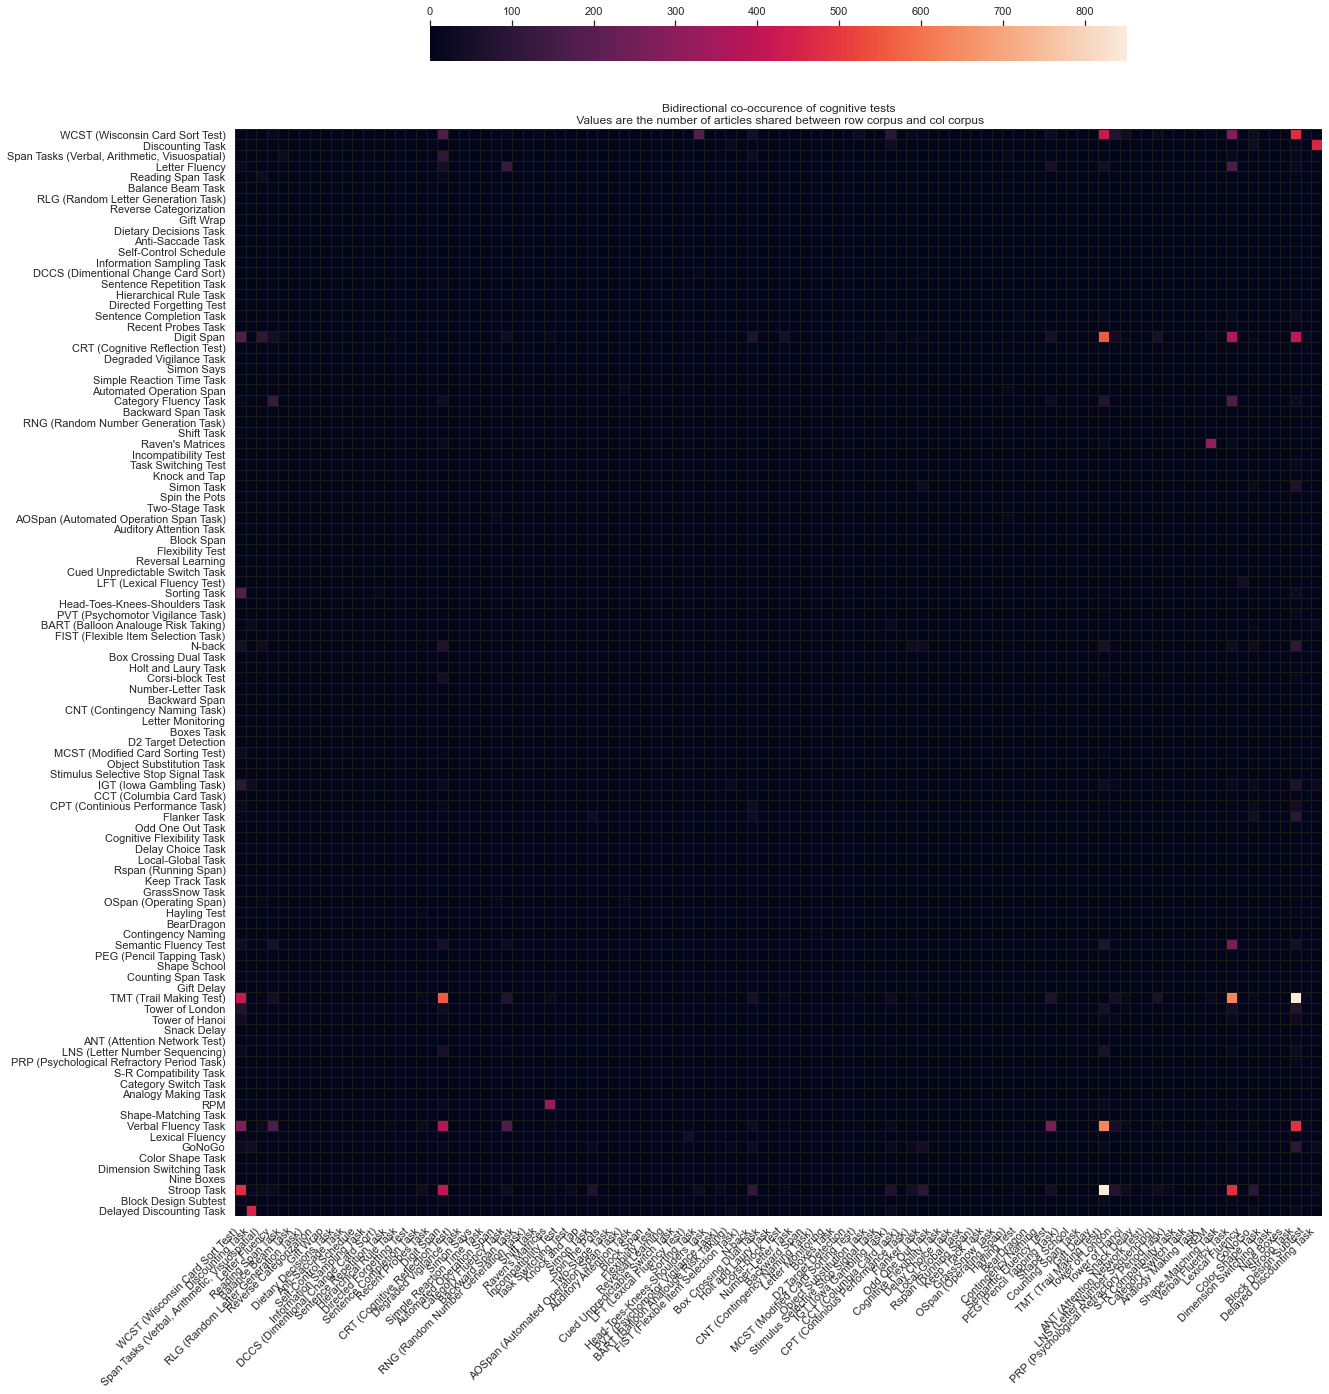

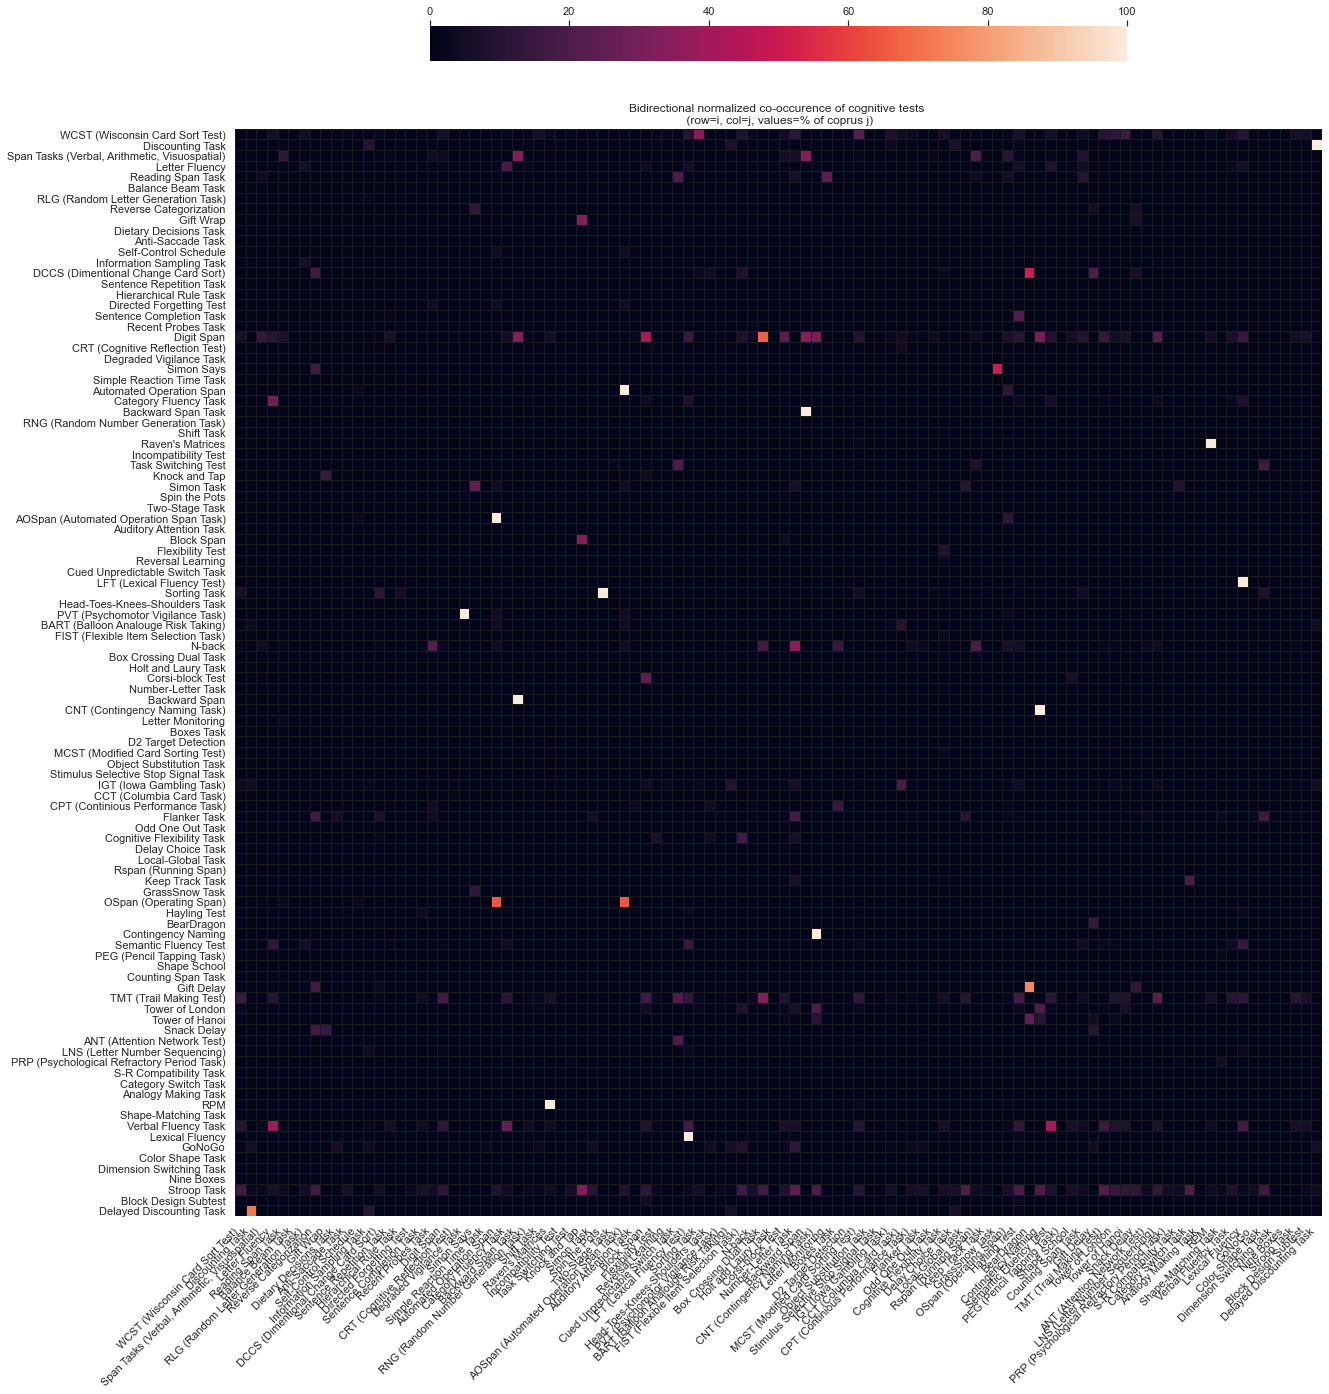

In [9]:
_, ax = plt.subplots(1,1,figsize=(25,25))
sns.heatmap(cooc,
            xticklabels=cognitive_tests,
            yticklabels=cognitive_tests,
            cbar_kws = {'use_gridspec':False, 'location':'top', 'shrink': .5},
            square=True,
            linewidths=.5,
            linecolor='k',
            ax=ax)

plt.xticks(rotation=45, ha='right') 
ax.set(title='Bidirectional co-occurrence of cognitive tests\n Values are the number of articles shared between row corpus and col corpus')
#plt.savefig('../outputs/co_occurrences/heatmap.png')
#plt.close()
plt.show()
# Now, same plot for the normalized co-occurrences matrix

_, ax = plt.subplots(1,1,figsize=(25,25))
sns.heatmap(cooc_normalized_pct,
            xticklabels=cognitive_tests,
            yticklabels=cognitive_tests,
            cbar_kws = {'use_gridspec':False, 'location':'top', 'shrink': .5},
            square=True,
            linewidths=.5,
            linecolor='k',
            ax=ax)

plt.xticks(rotation=45, ha='right') 
ax.set(title='Bidirectional normalized co-occurrence of cognitive tests \n (row=i, col=j, values=% of coprus j)')
#plt.savefig('../outputs/co_occurrences/heatmap_normalized.png')
#plt.close()
plt.show()

Here is the same heatmap, but tests are clustered:

In [24]:
# plot cluster map for co-occurrence counts
sns.clustermap(cooc,
            xticklabels=cognitive_tests,
            yticklabels=cognitive_tests,
            figsize=(15,15))

plt.xticks(rotation=45, ha='right') 
plt.suptitle('Bidirectional co-occurrence of cognitive tests')
plt.savefig('../outputs/co_occurrences/clustermap.png')
plt.close()

# plot cluster map for normalized co-occurrence
sns.clustermap(cooc_normalized_pct,
            xticklabels=cognitive_tests,
            yticklabels=cognitive_tests,
            figsize=(15,15))

plt.xticks(rotation=45, ha='right') 
plt.suptitle('Bidirectional normalized co-occurrence of cognitive tests\n(row=i, col=j, value=pct of corpus j)')
plt.savefig('../outputs/co_occurrences/clustermap_normalized.png')
plt.close()

/Users/pedro.cardosoleite/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/pedro.cardosoleite/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


## Visualization preprocessing 

Before plotting co-occurrence map as a graph, some preprocessing steps significantly improve the visuals:

1. remove low degree nodes and low weight edges.
2. Use degree centrality as node sizes; degree centrality shows number of connected edges to a given nodes (both inputs and outputs). Another measure that can be used for node sizes is the number of non-co-occurred articles that only mentioned once in the related test corpus.
3. Find communities in the graph, that are highly connected subgraphs. This property can be used to layout the graph and colorize the nodes.
4. Put co-occurred tests closer to each other by using force-driven spring layout.

I will use the de-facto NetworkX package to perform all the graph analysis listed above. The output will be a bidirectional graph that encapsulates centrality of each node, communities, edge widths, and positioning layout.

- [ ] **TODO:** greedy modulatiry algorithm returns one community because nodes are densly connected. Use another algorithm to extract some information from the graph structure.

In [29]:
# normalized co-occurrences below this threshold will be ignored
MIN_EDGE_WEIGHT = 5 # percent

# create graph from adjacency matrix
G = nx.from_numpy_matrix(cooc_normalized_pct, create_using=nx.DiGraph)

# set node labels
node_labels = {i:t for i,t in enumerate(cognitive_tests)}
nx.set_node_attributes(G, node_labels, 'label')

# remove low weight edges and low degree nodes
low_weight_edges = [(u,v) for u, v in G.edges() if G[u][v]['weight'] < MIN_EDGE_WEIGHT]
G.remove_edges_from(low_weight_edges)

low_degree_nodes = [n for n, d in G.degree() if d == 0]
G.remove_nodes_from(low_degree_nodes)


print(f'[INFO] After removing {len(low_weight_edges)} low-weight edges, {len(G.edges())} remained.')
print(f'[INFO] The following low-degree nodes are removed:\n', '\n '.join([cognitive_tests[ldn] for ldn in low_degree_nodes]))


# Community detection

def heaviest(G):
    from operator import itemgetter
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u,v)

import itertools


k = 2   # number of communities
communities = list(
        itertools.takewhile(lambda c: len(c) <= k, nx.community.girvan_newman(G, most_valuable_edge=heaviest))
    )[-1]

# this does not work for DiGraph
# communities = nx.community.greedy_modularity_communities(G,weight='weight')

community_index = {n: i for i, comm in enumerate(communities) for n in comm}
nx.set_node_attributes(G, community_index, 'community')


# compute centrality
centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'centrality')

# visual properties (all numeric values are relative, update them to match your canvas)
node_colors = community_index
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]


# compute layout positions
pos = nx.spring_layout(G, k=.8)

TypeError: Input graph is not a networkx graph type

# NetworkX plot (static)

In [28]:
import networkx as nx

In [118]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

nx.draw_networkx_nodes(G, pos,
                       node_color=list(node_colors.values()),
                       node_size=[max(10,v*10000) for v in centrality.values()],
                       alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=8, alpha=0.5, ax=ax)
# nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3, connectionstyle='arc3,rad=0.1')\n",
nx.draw_networkx_edges(G,
                       pos,
                       alpha=0.8,
                       arrowstyle='->',
                       arrowsize=10,
                       connectionstyle='arc3,rad=0.1',
                       width=[v/10 for v in  edge_widths],
                       edge_color='gainsboro',
                       ax=ax)

# plot the graph using matplotlib backend
plt.suptitle('Co-occurrence map\n Node size and edge width respectively show centrality degree and number of co-occurred articles in ith corpus.')
plt.tight_layout()
plt.savefig('../outputs/co_occurrences/map_networkx.png')
plt.close()

## Bokeh plot (interactive)

In [127]:

from bokeh.io import output_notebook, show; output_notebook()
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.plotting import from_networkx

plot = Plot(x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

graph_renderer = from_networkx(G, nx.spring_layout(G, k=5), scale=1, center=(0,0))

# data
graph_renderer.node_renderer.data_source.data['node_size'] = [max(10,v*100) for v in centrality.values()]
graph_renderer.edge_renderer.data_source.data['edge_size'] = [max(.1, v/5) for v in edge_widths]

# nodes
graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color='lightblue', line_color='white')
graph_renderer.node_renderer.selection_glyph = Circle(size='node_size', fill_color='mediumpurple', line_color='mediumpurple')
graph_renderer.node_renderer.nonselection_glyph = Circle(size='node_size', fill_color='lightblue', line_color='white')
graph_renderer.node_renderer.hover_glyph = Circle(size='node_size', fill_color='mediumpurple', line_color='mediumpurple')

# edges
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width='edge_size')
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color='mediumpurple', line_width='edge_size')
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color='mediumpurple', line_width='edge_size')

# tools
node_hover_tool = HoverTool(tooltips=[('Label','@label')])
plot.add_tools(node_hover_tool, TapTool())
graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

plot.title.text = "Interactive co-occurrence map of cognitive tests"
show(plot)

Loading BokehJS ...

## PyVis plot (interactive)

- [ ] **TODO:** bidirectional edges should be separated.

In [131]:
from pyvis.network import Network

nt = Network(height='1000px', width='1000px', directed=False, notebook=True, heading='Cognitive tests co-occurrence map')

nt.from_nx(G)

for i,n in enumerate(nt.nodes):
    n['size'] = max(10, n['centrality'] * 100)
    n['color'] = n['community']

for e in nt.edges:
    e['value'] = e['weight']



pyvis_options = """
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": 0,
      "centralGravity": 0,
      "springLength": 400,
      "springConstant": 0.1,
      "damping": 1,
      "avoidOverlap": 1
    }
  },
  "nodes": {
    "color": {
      "border": "white",
      "background": "lightblue",
      "highlight": {
        "border": "mediumpurple",
        "background": "mediumpurple"
      }
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      },
      "from": {
        "enabled": true
      }
    },
    "arrowStrikethrough": false,
    "color": {
      "color": "#dcdcdc88",
      "highlight": "mediumpurple",
      "inherit": false
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none"
    }
  }
}
"""

nt.set_options(pyvis_options)
# nt.show_buttons(filter_=['nodes'])

nt.show('../outputs/co_occurrences/map_pyvis.html')

### Plotly Sankey (interactive)

There are two sankey plots, first showing number of shared articles, and then percent of shared articles (normalized by target corpus).

In [11]:
import plotly.graph_objects as go

# uncomment to open fig in the browser instead of embedding into the notebook
# import plotly.io as pio; pio.renderers.default = 'browser'

MIN_CO_OCCURRENCE = 250

# prep data for sankey
cooc_df = pd.DataFrame(cooc).unstack().reset_index().rename(
  columns={'level_0': 'target', 'level_1': 'source', 0: 'co_occurrence'}
)

index_to_test_mapping = {i:c for i,c in enumerate(cognitive_tests)}
# df.replace({'task_i': index_to_test_mapping, 'task_j': index_to_test_mapping}, inplace=True)

# only pairs that appeared together at least 50 times
cooc_df = cooc_df.query('co_occurrence > @MIN_CO_OCCURRENCE')


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 10,
      line = dict(color = 'black', width = 0.5),
      label = cognitive_tests,
      color = 'lightblue'
    ),
    link = dict(
      source = cooc_df['source'],
      target = cooc_df['target'],
      value = cooc_df['co_occurrence']
  ))])

fig.update_layout(title_text=f'Co-occurrence sankey map (only pairs that appeared together in at least {MIN_CO_OCCURRENCE} articles of target corpus)', font_size=10)

fig.write_html('../outputs/co_occurrences/sankey_map_plotly.html')

fig.show()


Or plot the normalized percentages:

In [23]:
import plotly.graph_objects as go

# uncomment to open fig in the browser instead of embedding into the notebook
# import plotly.io as pio; pio.renderers.default = 'browser'

MIN_CO_OCCURRENCE_PCT = 20

# prep data for sankey
cooc_df = pd.DataFrame(cooc_normalized_pct).unstack().reset_index().rename(
  columns={'level_0': 'target', 'level_1': 'source', 0: 'co_occurrence_pct'}
)

index_to_test_mapping = {i:c for i,c in enumerate(cognitive_tests)}
# df.replace({'task_i': index_to_test_mapping, 'task_j': index_to_test_mapping}, inplace=True)

# only pairs that appeared together at least 50 times
cooc_df = cooc_df.query('co_occurrence_pct > @MIN_CO_OCCURRENCE_PCT')


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 10,
      line = dict(color = 'black', width = 0.5),
      label = cognitive_tests,
      color = 'lightblue'
    ),
    link = dict(
      source = cooc_df['source'],
      target = cooc_df['target'],
      value = cooc_df['co_occurrence_pct']
  ))])

fig.update_layout(title_text=f'Co-occurrence sankey map (only pairs that appeared together in at least {MIN_CO_OCCURRENCE_PCT}% of the target corpus)', font_size=10)

fig.write_html('../outputs/co_occurrences/sankey_map_normalized_plotly.html')

fig.show()
